In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa
import seaborn as sns

/home/energyls/micromamba/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


In [2]:
run = "nresults_full_3H_ws"
prefix = "/mnt/c/Users/scl38887/Documents/git/aldehyde/workflow/subworkflows/pypsa-earth-sec/results/" + run + "/postnetworks/"
output = "/mnt/c/Users/scl38887/Documents/git/aldehyde/results/" + run + "/graphics/rldc/"

In [3]:
path = "elec_s_10_ec_lc1.0_Co2L0.50_3H_2030_0.15_DF_20export.nc"
n = pypsa.Network(prefix + path)

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L0.50_3H_2030_0.15_DF_20export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


All nodes

In [4]:
capex = n.links[n.links.carrier == "H2 Electrolysis"].p_nom_opt * n.links[n.links.carrier == "H2 Electrolysis"].capital_cost
opex = n.links_t.p0.loc[:, n.links.carrier == "H2 Electrolysis"].sum() * n.snapshot_weightings.generators[0] * n.links[n.links.carrier == "H2 Electrolysis"].marginal_cost

In [5]:
el_cost = n.links_t.p0.loc[:, n.links.carrier == "H2 Electrolysis"].multiply(n.buses_t.marginal_price.loc[:, n.buses.carrier == "AC"].values, axis = 0).sum()

In [14]:
el_demand = n.links_t.p0.loc[:, n.links.carrier == "H2 Electrolysis"].sum(axis=0) * n.snapshot_weightings.generators[0]
p_nom_opt = n.links.p_nom_opt.loc[n.links.carrier == "H2 Electrolysis"]

In [15]:
cf = (n.links_t.p0.loc[:, n.links.carrier == "H2 Electrolysis"].sum(axis=0) * n.snapshot_weightings.generators[0]) / (n.links.p_nom_opt.loc[n.links.carrier == "H2 Electrolysis"] * 8760)

In [16]:
hydrogen = (-1) * n.links_t.p1.loc[:, n.links.carrier == "H2 Electrolysis"].sum() * n.snapshot_weightings.generators[0]

In [17]:
cost_comp = pd.concat([capex, opex, el_cost, hydrogen, cf], axis=1).reset_index(drop=True)
cost_comp.columns = ["capex", "opex", "el_cost", "hydrogen", "cf"]
cost_comp.index = hydrogen.index
cost_comp["total_cost"] = cost_comp["capex"] + cost_comp["opex"] + cost_comp["el_cost"]
cost_comp["capex_share"] = cost_comp["capex"] / cost_comp["total_cost"]
cost_comp["lcoh"] = cost_comp["total_cost"] / cost_comp["hydrogen"]

In [18]:
# Average CAPEX share
cost_comp["capex_share"].mean()
# Weighted average CAPEX share
cost_comp["capex"].mean() / cost_comp["total_cost"].mean()

0.4349481290836113

In [20]:
# Averaged CF
cost_comp["cf"].mean()
# Weighted Average CF -> equivalent to n.statistics() value
el_demand.mean() / (p_nom_opt.mean() * 8760)

0.5267997337784205

In [28]:
# LCOH 
cost_comp["lcoh"].mean()
(cost_comp["capex"].sum() + cost_comp["opex"].sum() + cost_comp["el_cost"].sum() ) / cost_comp["hydrogen"].sum()

54.711105421204415

In [31]:
# Average electricity price the electrolyzers see (using )
cost_comp["el_cost"] / (cost_comp["hydrogen"]/n.links[n.links.carrier == "H2 Electrolysis"].efficiency[0])

Link
MA.1.2_1_AC H2 Electrolysis     22.635232
MA.1.3_1_AC H2 Electrolysis     22.014311
MA.10.1_1_AC H2 Electrolysis    23.289085
MA.10.3_1_AC H2 Electrolysis    21.911423
MA.10.4_1_AC H2 Electrolysis    25.609241
MA.10.5_1_AC H2 Electrolysis    23.200762
MA.11.1_1_AC H2 Electrolysis    22.538171
MA.11.3_1_AC H2 Electrolysis    23.852547
MA.11.4_1_AC H2 Electrolysis    24.293819
MA.12.1_1_AC H2 Electrolysis    24.865695
MA.12.2_1_AC H2 Electrolysis    23.611656
MA.12.3_1_AC H2 Electrolysis    22.358935
MA.12.4_1_AC H2 Electrolysis    16.504813
MA.12.5_1_AC H2 Electrolysis    16.321939
MA.12.6_1_AC H2 Electrolysis    16.721907
MA.12.7_1_AC H2 Electrolysis    16.956099
MA.13.1_1_AC H2 Electrolysis    21.495144
MA.13.2_1_AC H2 Electrolysis    22.217379
MA.14.1_1_AC H2 Electrolysis    24.465529
MA.14.2_1_AC H2 Electrolysis    23.705421
MA.14.3_1_AC H2 Electrolysis    23.350619
MA.14.4_1_AC H2 Electrolysis    23.431332
MA.14.5_1_AC H2 Electrolysis    25.003949
MA.15.1_1_AC H2 Electrolysis 

Use n.statistics() for calculation

In [168]:
stats = n.statistics().loc["Link"].loc["H2 Electrolysis", :]

In [171]:
# LCOH without el cost (n.statistics)
(stats["Capital Expenditure"] + stats["Operational Expenditure"]) / stats["Supply"]

25.410110970545034

In [169]:
stats #["Capacity Factor"]

Capacity Factor            5.125599e-01
Capital Expenditure        5.274594e+08
Curtailment                         NaN
Dispatch                  -3.054495e+07
Installed Capacity         0.000000e+00
Market Value              -1.727849e+01
Operational Expenditure    3.230538e+05
Optimal Capacity           6.802847e+03
Revenue                    5.277708e+08
Supply                     2.077057e+07
Withdrawal                -3.054495e+07
Name: H2 Electrolysis, dtype: float64

Plotting

In [ ]:
# Plot the cost components: CAPEX, OPEX, el_cost
import matplotlib.pyplot as plt




Plot Prices (Fneum)

In [46]:
def get_nodal_prices(n):
    return (
        n.buses_t.marginal_price.mean()
        .groupby([n.buses.location, n.buses.carrier])
        .first()
        .unstack()
    )

In [47]:
df = get_nodal_prices(n)

In [48]:
df.head()

carrier,AC,H2,Li ion,battery,biogas,co2,co2 stored,gas,gas for industry,oil,...,residential urban decentral heat,residential urban decentral water tanks,services rural heat,services rural water tanks,services urban decentral heat,services urban decentral water tanks,solid biomass,solid biomass for industry,urban central heat,urban central water tanks
location,,,,,,,,,,,,,,,,,,,,,
,85.035657,120.822785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Africa,NaN,NaN,NaN,NaN,NaN,-106.46955,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MA.1.2_1_AC,NaN,120.169592,81.016979,87.181381,58.624911,NaN,-24.401368,41.402959,0.0,50.009858,...,42.083610,42.111288,11.191383,13.334834,20.291556,20.589419,-7.512846,-39.425726,40.984718,37.792411
MA.1.3_1_AC,NaN,120.630936,81.009461,87.181714,58.619191,NaN,-24.404282,41.406015,0.0,50.009159,...,41.238148,41.209787,11.199197,13.344439,20.097917,20.387571,-7.492763,-20.354925,41.411021,38.313732
MA.10.1_1_AC,NaN,121.032496,81.010375,87.300751,58.634035,NaN,-24.524425,41.405629,0.0,50.009932,...,43.222481,43.279830,11.375157,13.553696,20.422858,20.712863,-7.491167,-39.355996,42.132135,38.863052


In [49]:
def plot_price_duration_curve(n, carrier, fn=None):
    df = n.buses_t.marginal_price.loc[:, n.buses.carrier == carrier]

    df = df.stack()

    to_plot = df.sort_values(ascending=False).reset_index(drop=True)

    to_plot.index = [i / len(df) * 100 for i in to_plot.index]

    fig, ax = plt.subplots(figsize=(4, 2.5))
    to_plot.plot(
        ax=ax,
    )
    plt.xlabel("share of snapshots and nodes [%]")
    plt.ylabel("nodal price [EUR/MWh]")
    plt.axvline(0, linewidth=0.5, linestyle=":", color="grey")
    plt.axvline(100, linewidth=0.5, linestyle=":", color="grey")
    plt.axhline(0, linewidth=0.5, linestyle=":", color="grey")

    if carrier == "H2":
        title = "Hydrogen"
        plt.ylim([-20, 350])
    elif carrier == "AC":
        title = "Electricity"
        plt.ylim([-100, 1000])
    else:
        title = carrier

    plt.title(title, fontsize=12, color="#343434")

    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

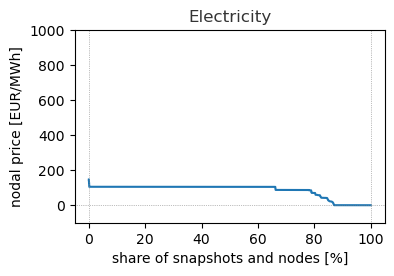

In [51]:
plot_price_duration_curve(n, "AC")

In [102]:
def plot_cf_heatmap(
    df, vmin=0, vmax=80, cmap="Greens", label="capacity factors [%]", fn=True
):
    fig, ax = plt.subplots(figsize=(6, 2.5))
    sns.heatmap(
        df,
        cmap=cmap,
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cbar_kws=dict(label=label, extend="max"),
    )
    plt.ylabel("hour of the day")
    plt.xlabel("day of the year")
    plt.yticks(rotation=0)
    plt.title(carrier, fontsize=12)
    plt.tight_layout()
    plt.annotate("Style from: Neumann et al. (2023) \n http://dx.doi.org/10.2139/ssrn.4173442", 
            xy=(0.9, -0.8),  # Coordinates of the text, adjust as needed
            xycoords='axes fraction',  # Use normalized axes coordinates
            textcoords='offset points',  # Use offset from xy
            size=7,  # Adjust the size of the text
            xytext=(0, 10),  # Offset from the xy point
            ha='center',  # Horizontal alignment
            color='gray')  # Adjust the color of the text
    if fn:
        if not isinstance(fn, str):
            fn = f"{OUTPUT_SCENARIO}/cf-ts-{carrier}.pdf"
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

In [77]:
def unstack_day_hour(cfc):
    df = cfc.groupby(cfc.index.hour).agg(list)

    columns = pd.date_range(cfc.index[0], cfc.index[-1], freq="D").strftime("%-d %b")

    return pd.DataFrame(df.tolist(), index=df.index, columns=columns)

In [78]:
cf = n.buses_t.marginal_price.groupby(n.buses.carrier, axis=1).mean()

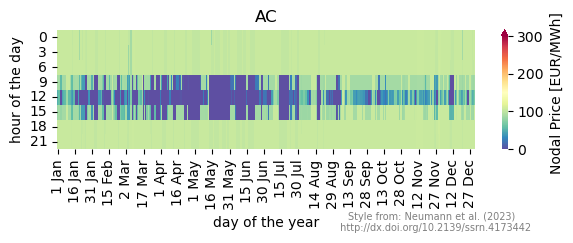

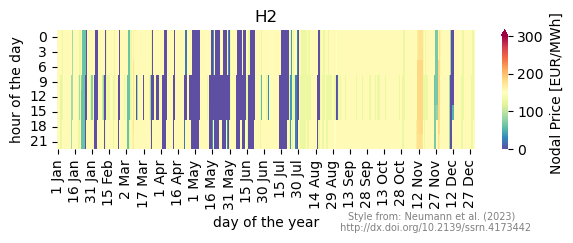

In [103]:
# for carrier in cf.columns:
for carrier in ["AC", "H2"]:
    cfc = cf[carrier]
    df = unstack_day_hour(cfc)
    vmax = np.ceil(cfc.quantile(0.99) / 10) * 10
    if carrier in ["AC", "H2"]:
        vmax = 300
    plot_cf_heatmap(
        df,
        cmap="Spectral_r",
        label="Nodal Price [EUR/MWh]",
        vmax=vmax,
        fn=False,
    )

In [66]:
def aggregate_techs(tech):
    if "solar thermal" in tech:
        return "solar thermal"
    elif "solar" in tech:
        return "solar PV"
    elif "offwind" in tech:
        return "offshore wind"
    elif "onwind" in tech:
        return "onshore wind"
    elif "ror" in tech:
        return "run of river"
    elif "ground heat pump" in tech:
        return "ground-sourced heat pump"
    elif "air heat pump" in tech:
        return "air-sourced heat pump"
    elif "water tank" in tech:
        return "thermal energy storage"
    elif tech == "H2":
        return "hydrogen storage"
    elif tech == "Li ion":
        return "electric vehicle batteries"
    elif "gas boiler" in tech:
        return "gas boiler"
    elif "resistive heater" in tech:
        return "resistive heater"
    elif "CHP" in tech:
        return "CHP"
    else:
        return tech

SOCs

In [105]:
cf = (
    n.stores_t.e.groupby(n.stores.carrier, axis=1).sum()
    / n.stores.e_nom_opt.groupby(n.stores.carrier).sum()
    * 100
)
cf = cf.groupby(cf.columns.map(aggregate_techs), axis=1).mean()

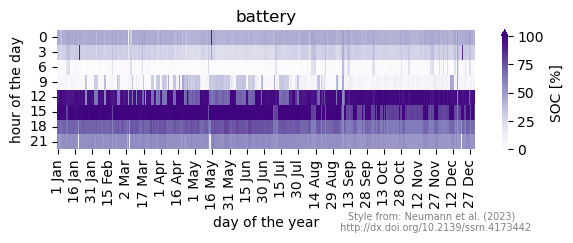

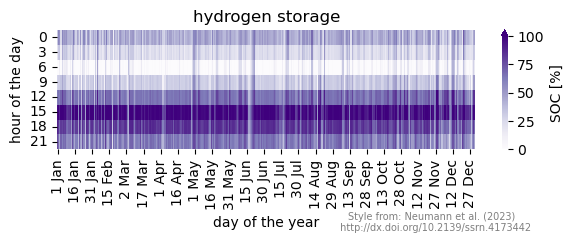

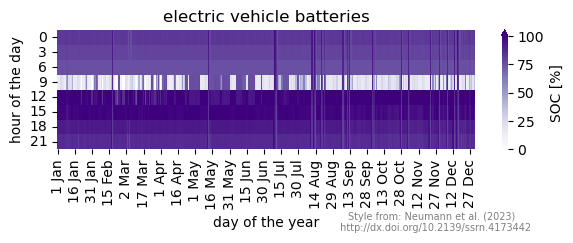

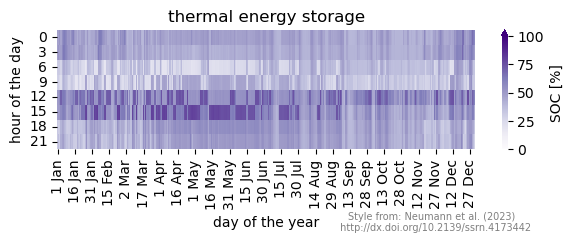

In [106]:
for carrier in ["battery", "hydrogen storage", "electric vehicle batteries", "thermal energy storage"]: #cf.columns:
    cfc = cf[carrier]
    df = unstack_day_hour(cfc)
    plot_cf_heatmap(df, cmap="Purples", vmin=0, vmax=100, label="SOC [%]", fn=False)

Marginal price

In [129]:

n.buses_t.marginal_price.loc[:, n.buses.carrier == "H2"].mean() #.iloc[:, 0] #.plot() # .describe() #).sum()

Bus
H2 export bus      120.822785
MA.1.2_1_AC H2     120.169592
MA.1.3_1_AC H2     120.630936
MA.10.1_1_AC H2    121.032496
MA.10.3_1_AC H2    121.015940
MA.10.4_1_AC H2    120.987313
MA.10.5_1_AC H2    121.024270
MA.11.1_1_AC H2    120.951033
MA.11.3_1_AC H2    120.956471
MA.11.4_1_AC H2    120.980384
MA.12.1_1_AC H2    119.305672
MA.12.2_1_AC H2    119.343146
MA.12.3_1_AC H2    119.266070
MA.12.4_1_AC H2    119.075176
MA.12.5_1_AC H2    119.128703
MA.12.6_1_AC H2    119.539017
MA.12.7_1_AC H2    119.079802
MA.13.1_1_AC H2    119.643212
MA.13.2_1_AC H2    120.004620
MA.14.1_1_AC H2    120.981902
MA.14.2_1_AC H2    121.046998
MA.14.3_1_AC H2    120.969567
MA.14.4_1_AC H2    121.034954
MA.14.5_1_AC H2    121.031520
MA.15.1_1_AC H2    120.978270
MA.15.2_1_AC H2    121.051495
MA.15.3_1_AC H2    121.102970
MA.2.1_1_AC H2     120.812890
MA.2.2_1_AC H2     120.159276
MA.3.2_1_AC H2     121.017493
MA.3.3_1_AC H2     121.058101
MA.3.4_1_AC H2     121.023295
MA.4.1_1_AC H2     120.970949
MA.4.2

Electrolyzers are active when the electricity prices are low

<AxesSubplot:xlabel='snapshot'>

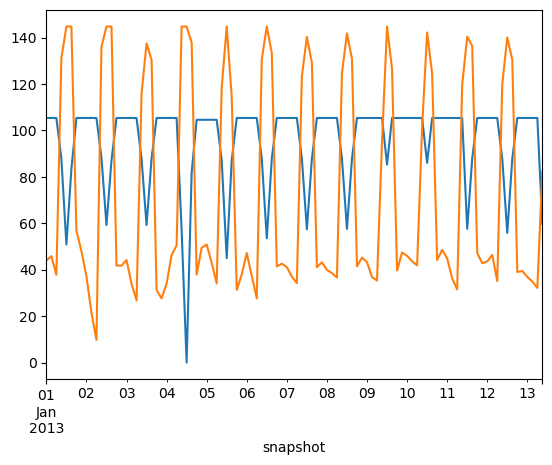

In [45]:
n.buses_t.marginal_price.loc[:, n.buses.carrier == "AC"].mean(axis=1)[:100].plot()
# n.buses_t.marginal_price.loc[:, n.buses.carrier == "H2"].mean(axis=1)[:400].plot()
n.links_t.p0.loc[:, n.links.carrier == "H2 Electrolysis"].mean(axis=1)[:100].plot()